# Trade Size Distributions and Befords Law

In [86]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from math import log10
cwd = os.getcwd()
#List of csv collections
collectionCSVs = [
    "0n1_force.csv",
    "axie_infinity.csv",
    "azuki.csv",
    "bored_ape.csv",
    "clone_x.csv",
    "coolmonkes.csv",
    "creature_world.csv",
    "creepz_reptile.csv",
    "creeps.csv",
    "cryptoadz.csv",
    "cryptobatz.csv",
    "cryptokitties.csv",
    "cryptopunks.csv",
    "cryptoskulls.csv",
    "cyberkongz_vx.csv",
    "DeadFellaz.csv",
    "decentraland_wearables.csv",
    "doge_pound.csv",
    "doodles.csv",
    "dr_ETHvil.csv",
    "emblem_vaul.csv",
    "FLUF_world_thingies.csv",
    "fomo_mofos.csv",
    "full_send.csv",
    "hape_prime.csv",
    "hashmasks.csv",
    "lil_heroes.csv",
    "lostpoets.csv",
    "meebits.csv",
    "mekaverse.csv",
    "metroverse.csv",
    "mutant_ape.csv",
    "my_curio_cards.csv",
    "phantabear.csv",
    "pudgypenguins.csv",
    "punkcomics.csv",
    "rarible.csv",
    "rtfkt.csv",
    "sorare.csv",
    "superrare.csv",
    "wolf_game.csv",
    "world of women.csv",
    "wvrps.csv",
    "x_rabbits.csv"
]

In [87]:
def first_sig_fig(number):
    """Returns the first significant digit of a provided number as string
    
    Parameters
    ----------
    number: The number whose first significant digit will be returned
    
    Raises
    ------
    TypeError: If the provided variable is not a number a TypeError will be raised
    """
    #Check that what is provided is actually a number
    if type(number) != int and type(number) != float and isinstance(number, numpy) == False:
        raise TypeError(f"{number} is not a number, it is of type {type(number)}")
    #Turn number into string so that it's iterable
    snumber = str(number)
    #Sentinel value to determine if we've hit the decimals yet.
    decimal_encountered = False
    for i in range(0,len(snumber)):
        if snumber[i].isdigit():
            temp = snumber[i]
            if snumber[i] == '0':
                pass
            else:
                return snumber[i]
        else:
            pass

In [88]:
def benford(array):
    """Takes in an array of prices as int or float and returns 
    the distribution of the first significant digit as a dict of each 
    digit and the respective count.
    
    Parameters
    ----------
    array: The numpy array to work with
    """
    c1, c2, c3, c4, c5, c6, c7, c8, c9 = 0, 0, 0, 0, 0, 0, 0, 0, 0
    for value in array:
        if first_sig_fig(value) == '1':
            c1 += 1
        elif first_sig_fig(value) == '2':
            c2 += 1
        elif first_sig_fig(value) == '3':
            c3 += 1
        elif first_sig_fig(value) == '4':
            c4 += 1
        elif first_sig_fig(value) == '5':
            c5 += 1
        elif first_sig_fig(value) == '6':
            c6 += 1
        elif first_sig_fig(value) == '7':
            c7 += 1
        elif first_sig_fig(value) == '8':
            c8 += 1
        elif first_sig_fig(value) == '9':
            c9 += 1
        else:
            raise Exception(f"First sig fig is not a number 1-9")
    counts = {'1':c1, '2':c2, '3':c3, '4':c4, '5':c5, '6':c6, '7':c7, '8':c8, '9':c9}
    return counts

In [89]:
def clean_panda(dataframe):
    """Takes in a Panda dataframe read from an opensea csv, drops bad rows, 
    bundle data, non ETH transactions then deletes original panda from memory.
    
    Params
    ------
    panda - The panda to take in
    
    Returns
    -------
    cleaned_dataframe - The cleaned dataframe"""
    
    def main(dataframe):
        dataframe = drop_bad_rows(dataframe)
        dataframe = drop_bundle(dataframe)
        dataframe = drop_nETH(dataframe)
        dataframe.reset_index(inplace=True, drop=True)
        return dataframe
    
    def drop_bad_rows(dataframe):
        ret = dataframe.dropna(subset=['total_price'])
        return ret
    
    def drop_bundle(dataframe):
        return dataframe.iloc[:, 1:150]
    
    def drop_nETH(dataframe):
        #What happens if there are no non ETH indices?
        bad_indices = dataframe[(dataframe.payment_token_id != 1) & (dataframe.payment_token_id != 2)].index
        ret = dataframe.drop(bad_indices)
        return ret
    
    return main(dataframe)

In [90]:
def make_adjprice(dataframe):
        #Make an adj_price column to represent ETH price
        adj_price = dataframe.apply(lambda row: float(row.total_price) / (10**row.payment_token_decimals), axis = 1)
        return adj_price

In [91]:
def roundness_check(adj_prices):
    def last_sig_fig(number):
        """Returns an integer indicating how many places after the decimal the last significant digit is. 1 returned is considered to be 
        the tenths place, while -1 would indicate the ones place
        
        Params
        ------
        number - the number to find the last sigfig of
        
        Returns
        -------
        The integer representation of the last sigfig's place"""
        
        if type(number) != float and type(number) != int:
            raise ValueError(f'{number} is neither a float or int')
        
        #Convert to string to use indexing
        strnum = str(number)
        
        def calc_ones(strnum):
            last_sig_index = -9999
            #Strip decimal if we have one
            if '.' in strnum:
                strnum = strnum[0:strnum.rfind('.')]
            #Get length -1 for range
            length = len(strnum)
            for i in range(0, length):
                if strnum[i] != '0':
                    last_sig_index = i
            if last_sig_index != -9999:
                return -(len(strnum) - last_sig_index)
            else:
                #Edge case where we're processing 0.0
                return -1
            
        #0 and 1 can both be confused in boolean expressions, uses a decided 'null' value instead.
        last_sig_index = -9999
        if '.' in strnum:
            #rfinds gets the index of last .
            dec_loc = strnum.rfind('.')
            for i in range(dec_loc+1, (len(strnum))):
                #Zeros after the . will never be the last sigfig
                if strnum[i]!='0':
                    last_sig_index = i
            #We found sigfig past decimal
            if last_sig_index != -9999:
                #Return the last occurence, but first calculate the place:
                return last_sig_index-dec_loc
        #If there isnt a decimal, or we didn't find a sigfig past
        return calc_ones(strnum)
    
    counts = np.empty(0)
    for adj_price in adj_prices:
        #Find the last significant digit
        place = last_sig_fig(adj_price)
        counts = np.append(counts, place)
        """if (place < -4) | (place > 5) | (place == 0):
            raise Exception(f'Sigfig was: {place} and adj_price = {adj_price}' +
                            '. Considered outside of the realized bounds, and therefore has not been accounted for')"""
        """#Then increment the list
        if place == -4:
            thousands = thousands+1
        elif place == -3:
            hundreds = hundreds+1
        elif place == -2:
            tens = tens + 1
        elif place == -1:
            ones = ones + 1
        elif place == 1:
            tenths = tenths + 1
        elif place == 2:
            hundreths = hundreths + 1
        elif place == 3:
            thousandths = thousandths + 1
        elif place == 4:
            ten_thousandths = ten_thousandths + 1
        elif place == 5:
            hundred_thousandths = hundred_thousandths + 1
            
    return {'hundred_thousandths':hundred_thousandths, 'ten_thousandths':ten_thousandths, 'hundreths': hundreths, 'tenths': tenths, 
           'ones':ones, 'tens':tens, 'hundreds':hundreds, 'thousands':thousands}"""
    number, occurrences = np.unique(counts, return_counts=True)
    returndict = {}
    j = 0
    for i in number:
        returndict[f'{i}']=occurrences[j]
        j = j + 1
    return returndict

In [92]:
def prep_pie(np_counts):
    labels = []
    counts = []
    for i in test:
        labels.append(i)
        counts.append(test[i])
    return labels, counts

In [93]:
def make_first_sig(adj_price):
    series = []
    for i in adj_price:
        series.append(first_sig_fig(i))
    return series

In [94]:
def make_eth_clusters(adj_price):
    """Takes in the adj price representing the total ETH/WETH traded, which is
    stored in the panda from opensea csv, returns two columns to be added by using the float round function.
    
    Params
    ------
    adj_price - The adj price series in a panda representing the ETH/WETH amounts
    
    Returns
    -------
    single_digit - A series containing the ETH/WETH as a single digit
    tenths - A series containing the ETH/WETH as a single digit and a tenths place round"""
    #Single round
    single_digit = []
    for i in adj_price:
        single_digit.append(round(i))
    #Tenths
    tenths = []
    for i in adj_price:
        tenths.append(round(i, 1))
    return single_digit, tenths

In [95]:
def BenfordChiTest(first_sig):
    """
    Returns Chi Square value
    A value over 15.507 has a p value of under .05, meaning
    data does not follow Benford's Law.
    
    Parameters
    ----------
    observed: Dict with <key,val> = <digit,occurrences>
    """
    # Make list of observed values in correct position
    observed = [0,0,0,0,0,0,0,0,0]
    for key in first_sig.keys():
        observed[int(key) - 1] = first_sig[key]
        
    size = sum(observed)
    expected = [size * log10(1 + 1/i) for i in range(1, 10)] # Computes expected values for each digit
    chiSquare = 0
    for (obs, exp) in zip(observed, expected):
        chiSquare = chiSquare + (obs - exp)**2/exp
    return chiSquare

In [96]:
"""fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()"""

"fig1, ax1 = plt.subplots()\nax1.pie(counts, labels=labels, autopct='%1.1f%%',\n        shadow=True, startangle=90)\nax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\n\nplt.show()"

In [97]:
#Load in another panda
#fomo_location = cwd + "/data/fomo_mofos.csv"
fomo_location = cwd + "/data/creepz.csv"
fomo = pd.read_csv(fomo_location, low_memory=False)

In [98]:
fomo = clean_panda(fomo)
fomo['adj_price'] = make_adjprice(fomo)

In [99]:
fomo['adj_price'].describe()

count    7236.000000
mean        2.841050
std         2.624852
min         0.000000
25%         0.890000
50%         1.350000
75%         4.700000
max        30.000000
Name: adj_price, dtype: float64

## Check for roundness

In [100]:
a = roundness_check(fomo['adj_price'])

In [101]:
"""labels, counts = prep_pie(a)
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()"""

"labels, counts = prep_pie(a)\nfig1, ax1 = plt.subplots()\nax1.pie(counts, labels=labels, autopct='%1.1f%%',\n        shadow=True, startangle=90)\nax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\n\nplt.show()"

### Making the first sig key for the panda

In [102]:
first_sig = make_first_sig(fomo['adj_price'])


In [103]:
fomo['eth_first_sig'] = first_sig

## First Significant Digit in ETH

In [104]:
fomo_first_counts = fomo['eth_first_sig'].value_counts()

<AxesSubplot:>

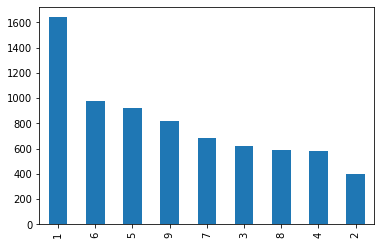

In [105]:
fomo_first_counts.plot(kind='bar')

In [118]:
ChiSquare = BenfordChiTest(fomo_first_counts)
print("Chi Square Value: " + str(ChiSquare)) # I'm getting massive Chi Square values

Chi Square Value: 2572.1603066174307


## First Significant Digit in USD converted from ETH

In [107]:
def make_usdprice(adj_price, payment_token_eth_price):
    series = []
    for i, j in zip(adj_price, payment_token_eth_price):
        series.append(i*j)
    return series

In [108]:
fomo['usd_price'] = make_usdprice(fomo['adj_price'], fomo['payment_token_usd_price'])

In [109]:
fomo['usd_first_sig'] = make_first_sig(fomo['usd_price'])

<AxesSubplot:>

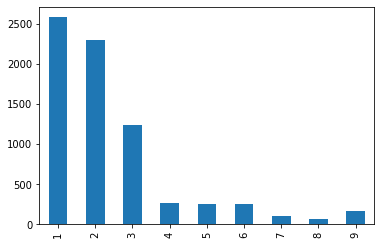

In [110]:
fomo['usd_first_sig'].value_counts().sort_index().plot(kind='bar')

In [111]:
fomo['usd_first_sig'].value_counts()

1    2583
2    2297
3    1243
4     270
5     254
6     249
9     165
7     100
8      73
Name: usd_first_sig, dtype: int64

In [117]:
ChiSquare = BenfordChiTest(fomo['usd_first_sig'].value_counts())
sum(observed)
print("Chi Square Value: " + str(ChiSquare)) # I'm getting massive Chi Square values

Chi Square Value: 2146.3801455508356


### This plot follows Benfords Law a little better, but highly affected by clustering 

## Tail Distribution

In [40]:
#What is the appropriate data to be thrown into powerlaw? Counts of the values and their frequency?
#By percentage? Looking into this
fit = powerlaw.Fit(fomo['usd_price'].value_counts())

Calculating best minimal value for power law fit


In [41]:
fit.power_law.alpha

1.794262254097783

In [42]:
fit.power_law.sigma

0.034116485077311624

In [43]:
fit.distribution_compare('power_law', 'exponential')

(377.39811815360446, 2.4656191507292515e-18)

In [44]:
fomo_value_counts = fomo['usd_price'].value_counts()

## Trade Clustering

In [45]:
single, tenths = make_eth_clusters(fomo['adj_price'])

In [46]:
fomo['eth_single'] = single
fomo['eth_tenth'] = tenths

<AxesSubplot:>

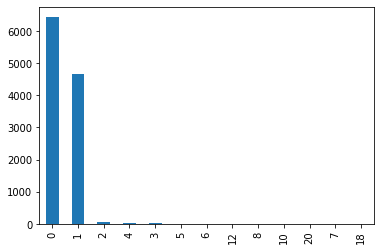

In [48]:
fomo['eth_single'].value_counts().plot(kind='bar')

<AxesSubplot:>

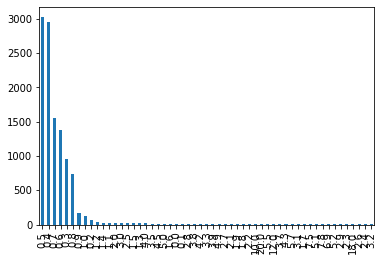

In [51]:
fomo['eth_tenth'].value_counts().plot(kind='bar', xlim=(0,10))

In [60]:
fomo['eth_tenth'].value_counts()[:1.0]

0.5    3021
0.4    2953
0.7    1550
0.6    1374
0.3     960
0.8     744
0.9     166
1.0     130
Name: eth_tenth, dtype: int64

In [61]:
sorted_value_counts = fomo['eth_tenth'].value_counts().sort_index()

In [70]:
sorted_value_counts

0.0        8
0.1        5
0.2       65
0.3      960
0.4     2953
0.5     3021
0.6     1374
0.7     1550
0.8      744
0.9      166
1.0      130
1.1       23
1.2       44
1.3       19
1.4       25
1.5       20
1.6        9
1.7        1
1.8        3
1.9        3
2.0       22
2.1        3
2.2        3
2.3        1
2.4        1
2.5       20
2.6        1
2.7        3
2.8        5
2.9        1
3.0       21
3.1        1
3.2        1
3.3        4
3.5       10
3.7        1
3.8        4
3.9        3
4.0       16
4.2        4
4.3        1
4.5        9
4.9        3
5.0        9
5.1        1
5.2        1
5.5        2
5.7        1
6.9        1
7.5        1
7.8        1
10.0       2
12.0       2
18.0       1
20.0       2
Name: eth_tenth, dtype: int64

(array([1.300e+01, 6.500e+01, 3.913e+03, 3.021e+03, 2.924e+03, 7.440e+02,
        2.960e+02, 2.300e+01, 6.300e+01, 2.500e+01, 2.900e+01, 1.000e+00,
        6.000e+00, 2.200e+01, 6.000e+00, 1.000e+00, 2.100e+01, 1.000e+00,
        8.000e+00, 2.200e+01]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ]),
 <BarContainer object of 20 artists>)

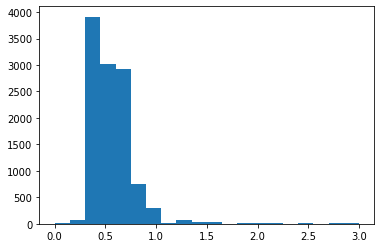

In [79]:
#range=(tuple) changes the x axis amount
#bins sets the 
plt.hist(fomo['eth_tenth'], align='mid', bins=20, range=(0,3))

In [81]:
fomo['eth_single'].value_counts()

0     6434
1     4659
2       79
4       45
3       41
5       14
6        3
12       2
8        2
10       2
20       2
7        1
18       1
Name: eth_single, dtype: int64